# Validation

In [1]:
from mat4py import loadmat
import numpy as np

class data_class():
	__data = []
	__len = 0
	__x = np.ndarray
	__t = np.ndarray
	__counter = 0 # n-te auto kolonne
	__unterCounter = 0 # n-ter Datenpunkt der Autos der __counter kolonne 
	__xIt = np.ndarray
	__tIt = np.ndarray
	__ItError = np.ndarray
	__numx = np.ndarray	
	__J = np.ndarray
	__d = np.ndarray
	__gesx = []
	__gesnumx = []
	__gesJ = []

	def get_gesJ(self):
		return self.__gesJ
	def get_d(self):
		return self.__d
	def get_numx(self):
		return self.__numx
	def get_J(self):
		return self.__J
	def get_gesx(self):
		return self.__gesx
	def get_gesnumx(self):
		return self.__gesnumx
	def get_len(self):
		return self.__len
	def get_x(self):
		return self.__x
	def get_t(self):
		return self.__t
	def get_tIt(self):
		return self.__tIt
	def get_xIt(self):
		return self.__xIt
	def get_ItError(self):
		return self.__ItError
	def set_x(self, x):
		self.__x = x
		return 
	def set_t(self, x):
		self.__t = x
		return
	def set_counter(self, x):
		self.__counter = x
		return
	
	def __init__(self, path):
		self.__data = loadmat(path)["sequences"][:]
		self.__len = len(self.__data)
		self.__counter = 0
		self.setXYTFromData(self.__counter)
		self.__gesx = []
		self.__gesnumx = []
		self.__gesJ = []
		return
	
	def setXYTFromData(self, x):
		self.__x = np.array(self.__data[x][0].get("Xarr"))
		self.__t = np.array(self.__data[x][0].get("Tarr"))
		return 
	
	def next_dataset(self, dataset_num = None):
		if dataset_num == None:
			if self.__counter < self.__len - 1:
				self.__counter += 1
				self.setXYTFromData(self.__counter)
				self.__unterCounter = 0
				return
			else:
				self.__counter += 1
				print(f"Error: Index {self.__counter} is out of range of the dataset with length {self.__len} !!!")
				return
		else:
			if dataset_num < self.__len - 1:
				self.__counter = dataset_num
				self.setXYTFromData(self.__counter)
				self.__unterCounter = 0
				return
			else:
				self.__counter = dataset_num
				print(f"Error: Index {self.__counter} is out of range of the dataset with length {self.__len} !!!")
				return

	def getCurrentCoords(self, i=None):
		if i == None:
			i = self.__unterCounter
		maxZeilen = self.__x.shape[0]
		maxSpalten = self.__x.shape[1]
		xVals = np.array([self.__x[j, i] for j in range(maxZeilen) if i < maxSpalten])
		tVal = self.__t[i] if i < maxSpalten else None

		if i == self.__unterCounter:
			self.__unterCounter += 1
		return xVals, tVal

	def J(self, x, dt, x_data):
		return np.sum(dt * np.power(np.linalg.norm(x - x_data, axis=0), 2))
	
	def set_numx(self, dt, L, v_max, n_dataset = __counter, model = "log"):
		self.next_dataset(n_dataset) # auf den gewollten Datensatz wechseln
		self.LinInterplation(dt) # durchschnittlicher Fehler der Interpolation abfragen
		self.switch_iteration() # Die interpolierten werte als zu berücksichtigende Daten setzen
		self.__numx = np.zeros_like(self.get_x()) # Array definieren, in dem die numerisch bestimmten orte gespeichert werden
		for i in range(self.get_x().shape[1]):
			x_soll, t_soll = self.getCurrentCoords() # Aktuelle ort, zeit punkte der autos ausgeben
			if i != 0: # Falls wir schon einen Schritt gegangen sind
				x, _ = self.single_step(x, v_max, L, dt, model) # x aktualisieren
			else: # Falls der erste durchlauf
				x, t = x_soll, t_soll # Startpositionen initialisieren
			self.__numx[:,i] = x
			t += dt
		self.__J = self.J(self.__numx, dt, self.__x) # Loss berechnen
		self.__gesx.append(self.__x)
		self.__gesnumx.append(self.__numx)
		self.__gesJ.append(self.__J)
		return	self.__numx

	def f (self, d, v_max, model = "log"):
		if model == "log":
			v = v_max * np.log(d)
			v[-1] = v_max		
			return v# np.min([v_max * np.log(d), np.ones_like(d) * v_max], 0) # Limit v_max, wie im linearen modell
		else: # lin
			return v_max * (1 - 1/d)
	
	def single_step(self, x, v_max, L, dt, model):
		N = len(x) # Number of initial values == number of vehicles in traffic
		dx = np.zeros(N) # momente initialisieren
		# Leader
		# dx[-1] = v_max
		dist = self.d(x)/L
		# for i in range(N):
		#         dx[i] = f(dist[i], v_max, model)
		dx = self.f(dist, v_max, model)
		return x + dt * dx, dx


	def switch_iteration(self):
		copy_x = self.__x.copy()
		copy_t = self.__t.copy()
		self.__x = self.__xIt 
		self.__t = self.__tIt 
		self.__xIt = copy_x
		self.__tIt = copy_t

	def test_correl(self, limit = 0.03):	
		corell = np.zeros(self.__x.shape[0])
		for i, auto in enumerate(self.__x):
			corell[i] = 1 - np.corrcoef(self.__t, auto)[0, 1]
		if np.sum(corell >= limit) >= 1:
			print(f"ACHTUNG mindestenz einmal eine größere Abweichung als {limit}")
		self.__ItError = corell
		return corell


	def test_interpolation(self, dt):
		rel_fehler = np.zeros(self.__x.shape[0])
		for i, auto in enumerate(self.__x):
			for x, t in zip(auto, self.__t):
				index = np.where((self.__tIt >= (t - dt/2)) & (self.__tIt <= (t + dt/2)))[0]
				if len(index) != 0:
					abs_fehler = np.abs(x-self.__xIt[i, index])
					rel_fehler[i] = rel_fehler[i] + abs_fehler/np.abs(x)
		avg_fehler = rel_fehler/len(self.__t)
		if np.sum(avg_fehler >= 0.05) > 1:
			print("ACHTUNG mindestenz einmal eine größere Abweichung als 5%")
		self.__ItError = avg_fehler
		return avg_fehler

	def LinApprox(self, dt=0.001):
		if np.sum(self.test_correl() >= 0.03) >= 1:
			print(f"ACHTUNG mindestenz einmal eine größere Abweichung als {0.03}")
		
		ort = self.__x
		zeit = self.__t
		zeit_int = np.arange(zeit[0], zeit[-1], dt)
		ort_int = np.zeros((ort.shape[0], len(zeit_int)))
		for i, auto in enumerate(ort):
			steigung = (np.max(auto)-np.min(auto))/(np.max(zeit)-np.min(zeit))
			ort_int[i,:] = steigung * np.arange(0, np.max(zeit)-np.min(zeit), dt) + np.min(auto)

		self.__xIt = ort_int
		self.__tIt = zeit_int
		# self.test_interpolation(dt)
		return ort_int, zeit_int


	def LinInterplation(self, dt=0.001):
		if np.sum(self.test_correl() >= 0.03) >= 1:
			print(f"ACHTUNG mindestenz einmal eine größere Abweichung als {0.03}")
		
		ort = self.__x
		zeit = self.__t
		zeit_int = np.arange(0, zeit[-1] - zeit[0], dt)
		ort_int = np.zeros((ort.shape[0],*zeit_int.shape))
		for i, auto in enumerate(ort):
			ort_int[i, :] = np.interp(zeit_int, zeit - zeit[0], auto)
		self.__xIt = ort_int
		self.__tIt = zeit_int
		# self.test_interpolation(dt)
		return ort_int, zeit_int
	
	def d(self, x:np.ndarray): # Abstandsfunktion
		d = np.ones_like(x) * np.inf # anfangs distanz auf sehr groß setzen
		order_mask = np.argsort(x) # nach i-ter achse sortieren, hier x achse -> 0
		x_ordered = x[order_mask]
		for i in range(len(x_ordered)-1):
			dist = np.linalg.norm(x_ordered[i] - x_ordered[i+1]) # Da die werte geordnet sind, muss nur die Distanz zum nächsten auto berücksichtigt werden
			d[i] = dist if d[i] > dist else d[i]
				
		reordered_d = d[np.argsort(order_mask)]
		return reordered_d

	def p1(self, dt, v_max, d):
		p1 = np.zeros_like(self.get_x()[0,:]) # anpassen
		t_arr = np.flip(self.get_t())
		for i, j in enumerate(t_arr):
			if i == 0:
				p = 0
			else:
				p = p + dt * 2*(self.get_numx()[0,-i-1]-self.get_x()[0,-i-1]) - dt * p * (v_max/d[-i-1]) # [-i-1] - "-1" ist dafür, damit tatsächlich bei bspw. i = 1, -> t = T - dt, das vorletzte element ausgewählt wird (index [-2])
			p1[-i-1] = p
		return p1

	def p2_N_1(self, dt, pi_1, dvorn, n, v_max, dhinten): # n tes auto
		pi = np.zeros_like(self.get_x()[1:-1,:])[0] # anpassen
		t_arr = np.flip(self.get_t())
		for i, j in enumerate(t_arr):
			if i == 0:
				p = 0
			else:
				p = p + dt * 2*(self.get_numx()[n,-i-1]-self.get_x()[n,-i-1]) - dt * p * (v_max/dvorn[-i-1]) + dt * pi_1[-i-1] * v_max/dhinten[-i-1]
			pi[-i-1] = p
		return pi

	def pN(self, dt, pi_1, d, v_max): # n tes auto
		pi = np.zeros_like(self.get_x()[1:-1,:])[0] # anpassen
		t_arr = np.flip(self.get_t())
		for i, j in enumerate(t_arr):
			if i == 0:
				p = 0
			else:
				p = p + dt * 2*(self.get_numx()[-1,-i-1]-self.get_x()[-1,-i-1]) + dt * pi_1[-i-1] * v_max/d[-i-1]
			pi[-i-1] = p
		return pi

	def pGes(self, dt, v_max):
		darr = np.array([self.d(i) for i in self.get_x().T])
		pges = np.zeros_like(self.get_x())
		pges[0,:] = self.p1(dt, v_max, darr[:,0])
		for n in range(1, pges.shape[0]-1):
			pges[n,:] = self.p2_N_1(dt, pges[n-1,:], darr[:,n], n, v_max, darr[:,n-1])
		pges[n+1,:] = self.pN(dt, pges[n,:], darr[:,-1], v_max)
		return pges

	def integral(self, arg, dt):
		res = np.array([arg[i] * dt for i in range(arg.shape[0])])
		return np.sum(res)

	def gradient(self, P_ges, d, v_max, L, dt):
		skvmax = self.integral(P_ges[-1,:] + np.sum(np.array([(P_ges[i,:] * (np.log(d[i,:] / L))) for i in range(P_ges.shape[0] - 1)]), axis=0), dt)
		skL = self.integral(np.sum(np.array([P_ges[i,:] * v_max/L for i in range(P_ges.shape[0]-1)]), axis=0), dt)
		# betrag = np.linalg.norm([skvmax, skL])
		return (skvmax, skL)# (skvmax/betrag, skL/betrag)

In [53]:
from opt_lib_1 import *
dt = 0.01
L_in = 10 # 15
L = L_in
vmax_in = 25 # 30
v_max = vmax_in
N = 1
M = 3000 # 5000
# # Datensatz 3
# L = 5 
# v_max = 30
# N = 1
# M = 5000 
# dt = 0.02
# sigma = 0.001
gradients = np.zeros((2, N))
vmax_arr = np.zeros(M)
L_arr = np.zeros(M)
sigma = [0.002, 0.002] # Amijo Bed.
np.random.seed(42)
grad_arr = np.zeros((M, 2))
J_arr_sammel = np.zeros(N) 
J_arr = np.zeros(M)
dataset_nuber = 10 # 5, 10
fileName = "TrafficDataset/sequence_data1-1_1.mat"
test = data_class(fileName)
for j in range(M):
	random_samples = [dataset_nuber]
    # random_samples = np.random.randint(0, test.get_len()-1, (N))
	for k, sample in enumerate(random_samples):
		test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
		Pges = test.pGes(dt, v_max)
		d = np.array([test.d(i) for i in test.get_x().T]).T
		Teil_grad = test.gradient(Pges, d, v_max, L, dt)
		# (update stepsize) bei uns fix
		gradients[:, k] = Teil_grad
		J_arr_sammel[k] = test.get_J()
	J_arr[j] = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
	vmax_arr[j] = v_max
	L_arr[j] = L
	mittel_grad = np.sum(gradients, 1)/N
	grad_arr[j,:] = mittel_grad
	if v_max + sigma[0] * mittel_grad[0] > 0:
		v_max = v_max + sigma[0] * mittel_grad[0]
	if L + sigma[1] * mittel_grad[1] > 0:
		L = L + sigma[1] * mittel_grad[1]


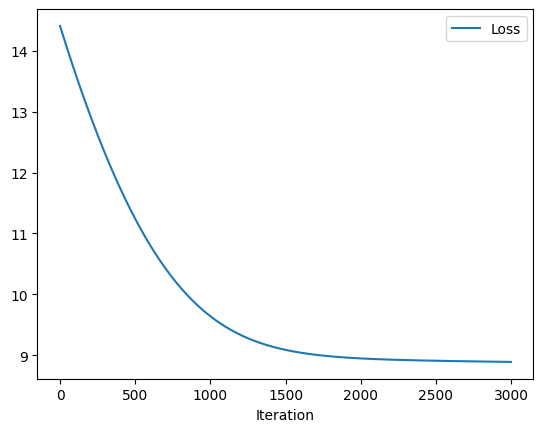

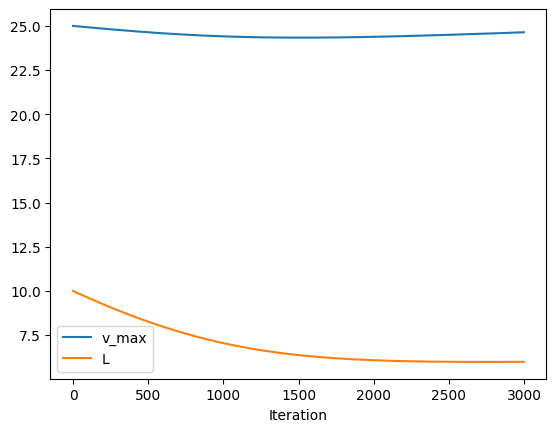

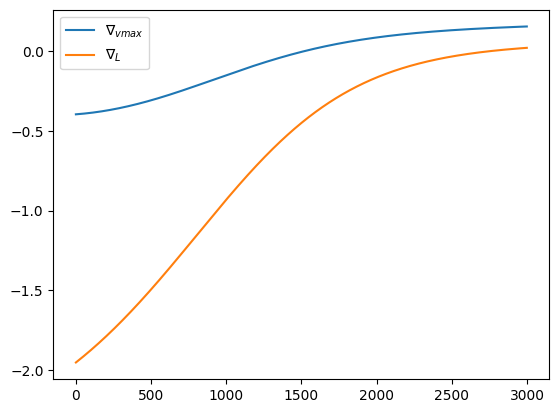

(np.float64(24.641648050616197), np.float64(5.988537121044375))

In [56]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(J_arr)), J_arr, label="Loss", marker = "")
ax = plt.gca()
# xmin, xmax = 3000, 8000
#ymin, ymax = 8, 9.5
#ax.set_ylim([ymin, ymax])
# ax.set_xlim([xmin, xmax])
plt.legend()
plt.xlabel("Iteration")
plt.savefig(f"Bilder/{fileName.split("/")[1].split(".")[0]}_single{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}Fixedsigma{sigma[0]}_Figure_Loss.pdf", dpi=40)
plt.show()
plt.plot(range(len(vmax_arr)), vmax_arr, label = "v_max", marker = "")
plt.plot(range(len(L_arr)), L_arr, label = "L",  marker = "")
plt.legend()
plt.xlabel("Iteration")
plt.savefig(f"Bilder/{fileName.split("/")[1].split(".")[0]}_single{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}Fixedsigma{sigma[0]}_Figure_ParameterEntwicklung.pdf", dpi=40)
plt.show()
plt.plot(range(grad_arr.shape[0]), grad_arr[:,0], label=r"$\nabla_{vmax}$", marker = "")
plt.plot(range(grad_arr.shape[0]), grad_arr[:,1], label=r"$\nabla_{L}$", marker = "")
plt.legend()
plt.savefig(f"Bilder/{fileName.split("/")[1].split(".")[0]}_single{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}Fixedsigma{sigma[0]}_Figure_GradEntwicklung.pdf", dpi=40)
plt.show()
v_max, L

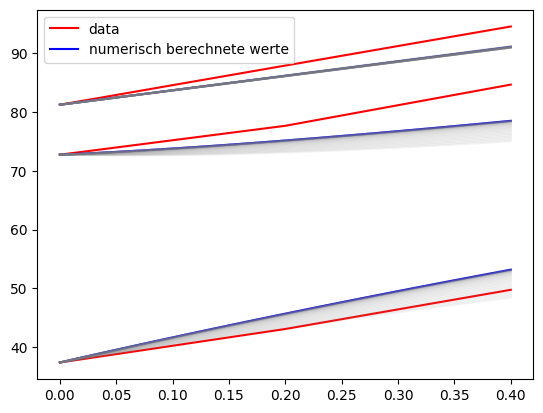

In [59]:
# OPtimiierungs prozess an trajektoreien zeigen
for i in range(test.get_x().shape[0]):
	if i == 0: 
		plt.plot(test.get_t(), test.get_x()[0,:], label="data", color = "r")
		plt.plot(test.get_t(),test.get_numx()[0,:],label="numerisch berechnete werte", color = "b")
	else:
		plt.plot(test.get_t(), test.get_x()[i,:], color = "r")
		plt.plot(test.get_t(),test.get_numx()[i,:], color = "b")

max = len(test.get_gesnumx())
for i in np.arange(0, max, 100):
    for j in range(test.get_x().shape[0]):
    	plt.plot(test.get_t(), test.get_gesnumx()[i][j,:], alpha = 0.1, color="gray")
plt.legend()
plt.savefig(f"Bilder/{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}Fixedsigma{sigma[0]}_Figure_Ges_IterationShadow.pdf", dpi=40)
plt.show()

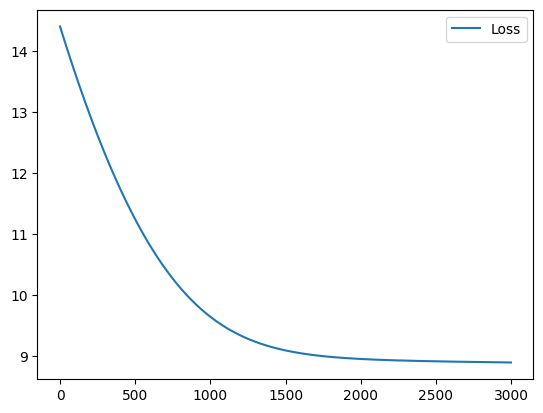

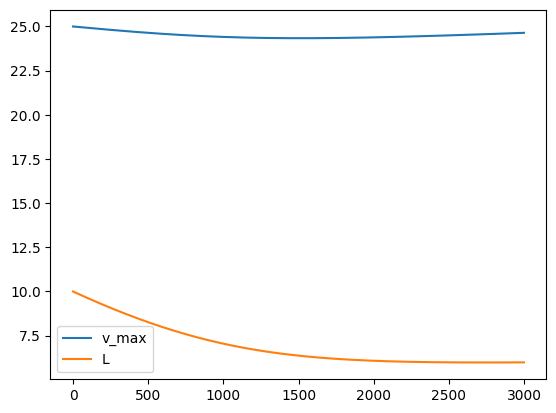

(np.float64(24.641648050616197), np.float64(5.988537121044375))

In [66]:
import matplotlib.pyplot as plt
def flatten(xss):
    return [x for xs in xss for x in xs]
Ges_J = test.get_gesJ()
plt.plot(np.arange(len(Ges_J)), Ges_J, label="Loss")
plt.legend()
plt.savefig(f"Bilder/Figure_Loss{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
plt.plot(np.arange(M), vmax_arr, label = "v_max")
plt.plot(np.arange(M), L_arr, label = "L")
plt.legend()
plt.savefig(f"Bilder/Figure_ParameterEntwicklung{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
v_max, L

In [61]:
zaehler = np.array([j-i for i, j in zip(J_arr[:-1], J_arr[1:])])
gard_norm_quad = np.power(np.linalg.norm(grad_arr, axis = 1), 2)
zaehler/0.001, -gard_norm_quad

(array([-19.86998445, -19.83124604, -19.79246673, ...,  -0.02676843,
         -0.0267148 ,  -0.02666114], shape=(2999,)),
 array([-3.97280109, -3.96537429, -3.95793493, ..., -0.0757918 ,
        -0.07582955, -0.07586732], shape=(3000,)))

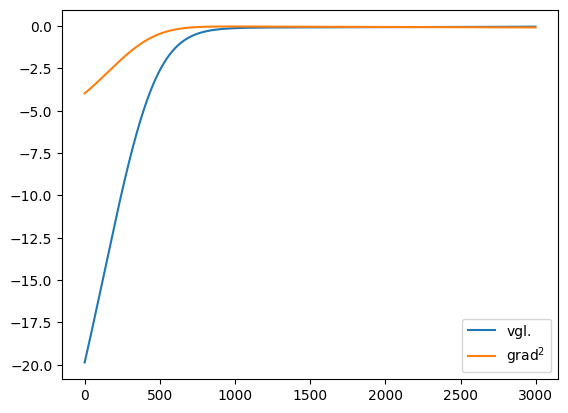

In [62]:
ax = plt.gca()
# xmin, xmax = 3000, 8000
# ymin, ymax = -0.1, 0.1
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])
plt.plot(range(M-1), zaehler/0.001, label = "vgl.")
plt.plot(range(M), -gard_norm_quad, label= r"grad$^2$")
plt.legend()

plt.savefig(f"Bilder/Figure_GradVgl{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()

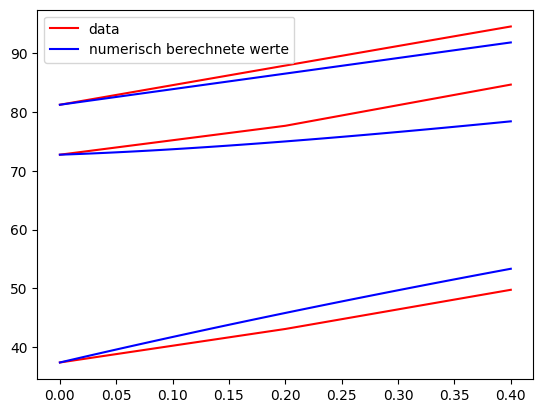

In [63]:
for i in range(test.get_x().shape[0]):
	if i == 0: 
		plt.plot(test.get_t(), test.get_x()[0,:], label="data", color = "r")
		plt.plot(test.get_t(),test.get_numx()[0,:],label="numerisch berechnete werte", color = "b")
	else:
		plt.plot(test.get_t(), test.get_x()[i,:], color = "r")
		plt.plot(test.get_t(),test.get_numx()[i,:], color = "b")

plt.legend()
plt.show()

In [43]:
fileName.split("/")[1].split(".")[0]

'sequence_data1-1_1'

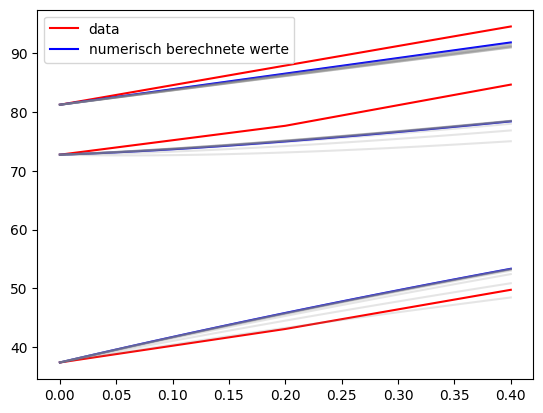

In [64]:
# OPtimiierungs prozess an trajektoreien zeigen
for i in range(test.get_x().shape[0]):
	if i == 0: 
		plt.plot(test.get_t(), test.get_x()[0,:], label="data", color = "r")
		plt.plot(test.get_t(),test.get_numx()[0,:],label="numerisch berechnete werte", color = "b")
	else:
		plt.plot(test.get_t(), test.get_x()[i,:], color = "r")
		plt.plot(test.get_t(),test.get_numx()[i,:], color = "b")


for i in np.arange(0, M, M//10):
    for j in range(test.get_x().shape[0]):
    	plt.plot(test.get_t(), test.get_gesnumx()[i][j,:], alpha = 0.2, color="gray")
plt.legend()
plt.savefig(f"Bilder/Figure_Ges_IterationShadow{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}.pdf", dpi=40)
plt.show()


# Armijo

In [2]:
 # from opt_lib_1 import *
dt = 0.001
L_in = 10 # 15
L = L_in
vmax_in = 25 # 30
v_max = vmax_in
N = 1
M = 100 # 5000
# # Datensatz 3
# L = 5 
# v_max = 30
# N = 1
# M = 5000 
# dt = 0.02
# sigma = 0.001
gradients = np.empty((2, N))
vmax_arr = np.empty(M)
L_arr = np.empty(M)
sigma = np.array([1/(2**i) for i in np.arange(0,30)]) # Amijo Bed.
np.random.seed(42)
grad_arr = np.empty((M, 2))
J_arr_sammel = np.empty(N) 
J_arr = np.empty(M)
dataset_nuber = 5# 5, 10
fileName = "TrafficDataset/sequence_data1-1_1.mat"
test = data_class(fileName)
gamma = 0.01 # erstmal fix



random_samples = [dataset_nuber]
for k, sample in enumerate(random_samples):
        test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
        Pges = test.pGes(dt, v_max)
        d = np.array([test.d(i) for i in test.get_x().T]).T
        Teil_grad = test.gradient(Pges, d, v_max, L, dt)
        # (update stepsize) bei uns fix
        gradients[:, k] = Teil_grad
        J_arr_sammel[k] = test.get_J()
mittel_grad = np.sum(gradients, 1)/N
J_initial = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]

Weiter = True
for j in range(M):
    random_samples = [dataset_nuber]
    #random_samples = np.random.randint(0, test.get_len()-1, (N))

    J_alt = J_vgl if j != 0 else J_initial
    for sig in sigma:
        kurz_vmax = v_max + sig * mittel_grad[0]
        kurz_L = L + sig * mittel_grad[1]
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            J_arr_sammel[k] = test.get_J()
            
        J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
        if J_mittel - J_alt <= (-1) * sig * gamma * np.power(np.linalg.norm(mittel_grad), 2):
            #print(f"Sigma hat funktioniert: {sig}")
            Weiter = True
            break
        if sig == np.min(sigma):
            #print(f"Kein Sigma gefunden in iteration: {j}")
            Weiter = False
    if Weiter:
        # für die gewählte Schrittweite die adjungierte etc bestimmen
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            Pges = test.pGes(dt, kurz_vmax)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, kurz_vmax, kurz_L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
            
        mittel_grad = np.sum(gradients, 1)/N
        J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
        # Das entsprechende Update mit ausgerechneter Schrittweite machen
        if v_max + sig* mittel_grad[0] > 0:
            v_max = v_max + sig * mittel_grad[0]
        if L + sig * mittel_grad[1] > 0:
            L = L + sig * mittel_grad[1]
        J_arr[j] = J_mittel
        J_vgl = J_mittel
        vmax_arr[j] = v_max
        L_arr[j] = L
        grad_arr[j,:] = mittel_grad
        
    

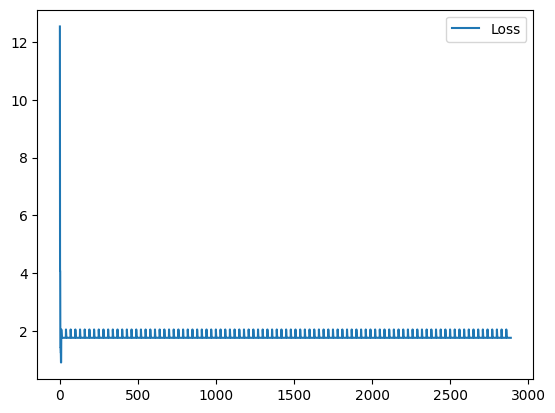

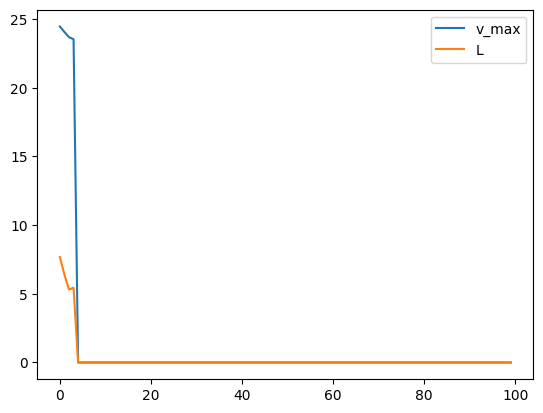

(np.float64(23.54045586873347), np.float64(5.438475254611865))

In [3]:
import matplotlib.pyplot as plt
def flatten(xss):
    return [x for xs in xss for x in xs]
Ges_J = test.get_gesJ()
plt.plot(np.arange(len(Ges_J)), Ges_J, label="Loss")
plt.legend()
plt.savefig(f"Bilder/Figure_Loss{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
plt.plot(np.arange(M), vmax_arr, label = "v_max")
plt.plot(np.arange(M), L_arr, label = "L")
plt.legend()
plt.savefig(f"Bilder/Figure_ParameterEntwicklung{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
v_max, L

In [13]:
 # from opt_lib_1 import *
dt = 0.01
L_in = 10 # 15
L = L_in
vmax_in = 25 # 30
v_max = vmax_in
N = 4
M = 100 # 5000
# # Datensatz 3
# L = 5 
# v_max = 30
# N = 1
# M = 5000 
# dt = 0.02
# sigma = 0.001
gradients = np.empty((2, N))
vmax_arr = []
L_arr = []
sigma = np.array([1/(2**i) for i in np.arange(3,30)]) # Amijo Bed.
np.random.seed(42)
grad_arr = np.empty((M, 2))
J_arr_sammel = np.empty(N) 
J_arr = []
dataset_nuber = 3# 5, 10
fileName = "TrafficDataset/sequence_data1-1_1.mat"
test = data_class(fileName)
gamma = 0.01 # erstmal fix



#random_samples = [dataset_nuber]
random_samples = np.random.randint(0, test.get_len()-1, (N))
for k, sample in enumerate(random_samples):
        test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
        Pges = test.pGes(dt, v_max)
        d = np.array([test.d(i) for i in test.get_x().T]).T
        Teil_grad = test.gradient(Pges, d, v_max, L, dt)
        # (update stepsize) bei uns fix
        gradients[:, k] = Teil_grad
        J_arr_sammel[k] = test.get_J()
mittel_grad = np.sum(gradients, 1)/N
J_initial = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]

Weiter = True
for j in range(M):
	#random_samples = [dataset_nuber]
	if j != 0:
		random_samples = np.random.randint(0, test.get_len()-1, (N))

	J_alt = J_vgl if j != 0 else J_initial
	if not Weiter:
		for k, sample in enumerate(random_samples):
			test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
			Pges = test.pGes(dt, kurz_vmax)
			d = np.array([test.d(i) for i in test.get_x().T]).T
			Teil_grad = test.gradient(Pges, d, kurz_vmax, kurz_L, dt)
			# (update stepsize) bei uns fix
			gradients[:, k] = Teil_grad
			J_arr_sammel[k] = test.get_J()
		
		mittel_grad = np.sum(gradients, 1)/N
		J_alt = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
		
	for sig in sigma:
		kurz_vmax = v_max + sig * mittel_grad[0]
		kurz_L = L + sig * mittel_grad[1]
		for k, sample in enumerate(random_samples):
			test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
			J_arr_sammel[k] = test.get_J()
			
		J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
		if J_mittel - J_alt <= (-1) * sig * gamma * np.power(np.linalg.norm(mittel_grad), 2):
			print(f"Sigma hat funktioniert: {sig}")
			Weiter = True
			break
		if sig == np.min(sigma):
			print(f"Kein Sigma gefunden in iteration: {j}, mit grad = {np.power(np.linalg.norm(mittel_grad), 2)}")
			Weiter = False
	if Weiter:
		# für die gewählte Schrittweite die adjungierte etc bestimmen
		for k, sample in enumerate(random_samples):
			test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
			Pges = test.pGes(dt, kurz_vmax)
			d = np.array([test.d(i) for i in test.get_x().T]).T
			Teil_grad = test.gradient(Pges, d, kurz_vmax, kurz_L, dt)
			# (update stepsize) bei uns fix
			gradients[:, k] = Teil_grad
			J_arr_sammel[k] = test.get_J()
			
		mittel_grad = np.sum(gradients, 1)/N
		J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
		# Das entsprechende Update mit ausgerechneter Schrittweite machen
		if v_max + sig* mittel_grad[0] > 0:
			v_max = v_max + sig * mittel_grad[0]
		if L + sig * mittel_grad[1] > 0:
			L = L + sig * mittel_grad[1]
		J_arr.append(J_mittel)
		J_vgl = J_mittel
		vmax_arr.append(v_max)
		L_arr.append(L)
		grad_arr[j,:] = mittel_grad
		
    

Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.125
Kein Sigma gefunden in iteration: 3, mit grad = 10.513800498569884
Sigma hat funktioniert: 0.125
Kein Sigma gefunden in iteration: 5, mit grad = 2.949900993575942
Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.125
Kein Sigma gefunden in iteration: 9, mit grad = 1.9441409857731506
Kein Sigma gefunden in iteration: 10, mit grad = 0.5320684672962788
Sigma hat funktioniert: 0.125
Kein Sigma gefunden in iteration: 12, mit grad = 1.350807811760828
Sigma hat funktioniert: 0.125
Kein Sigma gefunden in iteration: 14, mit grad = 31.055791160458075
Sigma hat funktioniert: 0.125
Kein Sigma gefunden in iteration: 16, mit grad = 16.81752705217225
Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.125
Kein Sigma gefunden in iteration: 20, mit grad = 5.443997408398332
Kein Sigma gefunden in iteration: 21, mit grad = 17908875.0417429
Sigma h

/tmp/ipykernel_2601/2748071197.py:216: RuntimeWarning: invalid value encountered in scalar subtract
  dist = np.linalg.norm(x_ordered[i] - x_ordered[i+1]) # Da die werte geordnet sind, muss nur die Distanz zum nächsten auto berücksichtigt werden


Kein Sigma gefunden in iteration: 25, mit grad = 7068801045340979.0
Kein Sigma gefunden in iteration: 26, mit grad = 1027070456.1130525
Sigma hat funktioniert: 4.76837158203125e-07
Kein Sigma gefunden in iteration: 28, mit grad = 13013.333950489836
Kein Sigma gefunden in iteration: 29, mit grad = 47482.72884893688
Kein Sigma gefunden in iteration: 30, mit grad = 1062064659.713267
Kein Sigma gefunden in iteration: 31, mit grad = 7069000178949710.0
Kein Sigma gefunden in iteration: 32, mit grad = 32904.750953598086
Kein Sigma gefunden in iteration: 33, mit grad = 1.2362263774453655e+75


/tmp/ipykernel_2601/2748071197.py:240: RuntimeWarning: invalid value encountered in scalar add
  p = p + dt * 2*(self.get_numx()[n,-i-1]-self.get_x()[n,-i-1]) - dt * p * (v_max/dvorn[-i-1]) + dt * pi_1[-i-1] * v_max/dhinten[-i-1]


Kein Sigma gefunden in iteration: 34, mit grad = nan
Kein Sigma gefunden in iteration: 35, mit grad = nan
Kein Sigma gefunden in iteration: 36, mit grad = nan
Kein Sigma gefunden in iteration: 37, mit grad = nan
Kein Sigma gefunden in iteration: 38, mit grad = nan
Kein Sigma gefunden in iteration: 39, mit grad = nan
Kein Sigma gefunden in iteration: 40, mit grad = nan
Kein Sigma gefunden in iteration: 41, mit grad = nan
Kein Sigma gefunden in iteration: 42, mit grad = nan
Kein Sigma gefunden in iteration: 43, mit grad = nan
Kein Sigma gefunden in iteration: 44, mit grad = nan
Kein Sigma gefunden in iteration: 45, mit grad = nan
Kein Sigma gefunden in iteration: 46, mit grad = nan
Kein Sigma gefunden in iteration: 47, mit grad = nan
Kein Sigma gefunden in iteration: 48, mit grad = nan
Kein Sigma gefunden in iteration: 49, mit grad = nan
Kein Sigma gefunden in iteration: 50, mit grad = nan
Kein Sigma gefunden in iteration: 51, mit grad = nan
Kein Sigma gefunden in iteration: 52, mit grad

KeyboardInterrupt: 

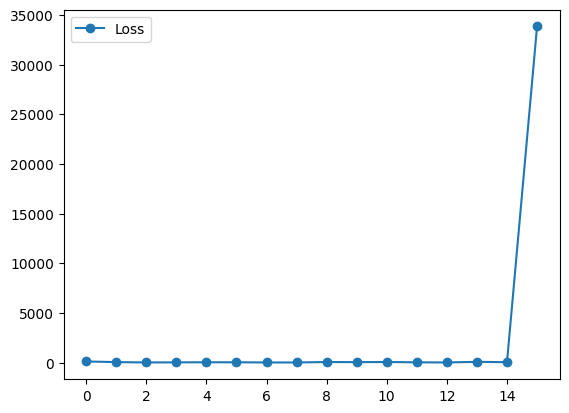

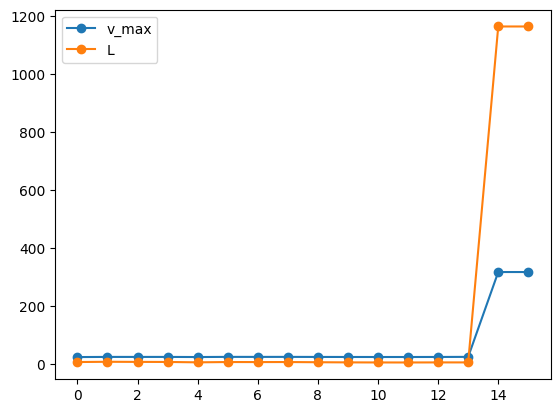

(np.float64(317.65395511853467), np.float64(1163.3890022469725))

In [14]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(J_arr)), J_arr, label="Loss", marker = "o")
ax = plt.gca()
# xmin, xmax = 3000, 8000
#ymin, ymax = 8, 9.5
#ax.set_ylim([ymin, ymax])
# ax.set_xlim([xmin, xmax])
plt.legend()
plt.savefig(f"Bilder/Figure_Loss{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
plt.plot(range(len(vmax_arr)), vmax_arr, label = "v_max", marker = "o")
plt.plot(range(len(L_arr)), L_arr, label = "L",  marker = "o")
plt.legend()
plt.savefig(f"Bilder/Figure_ParameterEntwicklung{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
v_max, L

In [15]:
L_arr[12], vmax_arr[12]


(np.float64(6.387977937080982), np.float64(25.1301138100662))

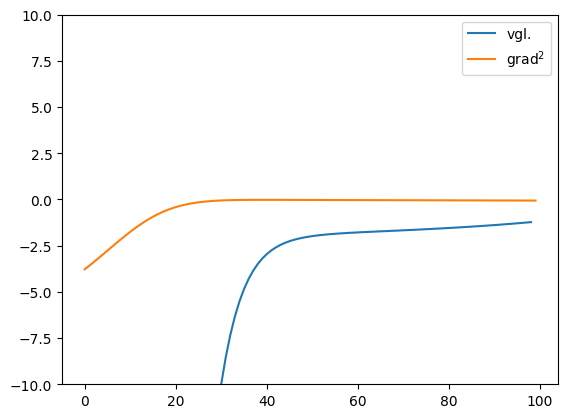

In [139]:
zaehler = np.array([j-i for i, j in zip(J_arr[:-1], J_arr[1:])])
gard_norm_quad = np.power(np.linalg.norm(grad_arr, axis = 1), 2)

ax = plt.gca()
# xmin, xmax = 3000, 8000
ymin, ymax = -10, 10
ax.set_ylim([ymin, ymax])
# ax.set_xlim([xmin, xmax])

plt.plot(range(M-1), zaehler/0.001, label = "vgl.")
plt.plot(range(M), -gard_norm_quad, label= r"grad$^2$")
plt.legend()

plt.savefig(f"Bilder/Figure_GradVgl{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()

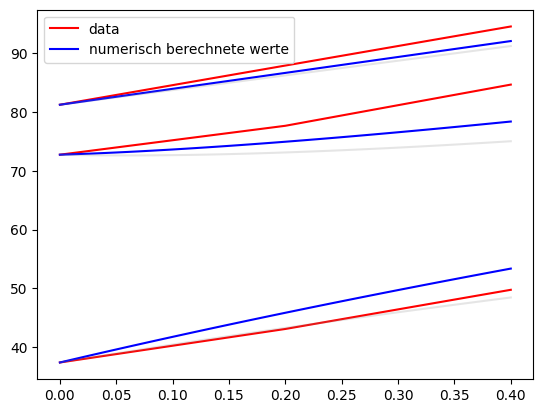

In [129]:
# OPtimiierungs prozess an trajektoreien zeigen
for i in range(test.get_x().shape[0]):
	if i == 0: 
		plt.plot(test.get_t(), test.get_x()[0,:], label="data", color = "r")
		plt.plot(test.get_t(),test.get_numx()[0,:],label="numerisch berechnete werte", color = "b")
	else:
		plt.plot(test.get_t(), test.get_x()[i,:], color = "r")
		plt.plot(test.get_t(),test.get_numx()[i,:], color = "b")


for i in np.arange(0, M, M):
    for j in range(test.get_x().shape[0]):
    	plt.plot(test.get_t(), test.get_gesnumx()[i][j,:], alpha = 0.2, color="gray")
plt.legend()
plt.savefig(f"Bilder/Figure_Ges_IterationShadow{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}.pdf", dpi=40)
plt.show()


In [163]:
 # from opt_lib_1 import *
dt = 0.01
L_in = 10 # 15
L = L_in
vmax_in = 25 # 30
v_max = vmax_in
N = 4
M = 100 # 5000
# # Datensatz 3
# L = 5 
# v_max = 30
# N = 1
# M = 5000 
# dt = 0.02
# sigma = 0.001
gradients = np.empty((2, N))
vmax_arr = []
L_arr = []
sigma = np.array([1/(2**i) for i in np.arange(0,30)]) # Amijo Bed.
np.random.seed(42)
grad_arr = np.empty((M, 2))
J_arr_sammel = np.empty(N) 
J_arr = []
dataset_nuber = 3# 5, 10
fileName = "TrafficDataset/sequence_data1-1_1.mat"
test = data_class(fileName)
gamma = 0.01 # erstmal fix



#random_samples = [dataset_nuber]
random_samples = np.random.randint(0, test.get_len()-1, (N))
for k, sample in enumerate(random_samples):
        test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
        Pges = test.pGes(dt, v_max)
        d = np.array([test.d(i) for i in test.get_x().T]).T
        Teil_grad = test.gradient(Pges, d, v_max, L, dt)
        # (update stepsize) bei uns fix
        gradients[:, k] = Teil_grad
        J_arr_sammel[k] = test.get_J()
mittel_grad = np.sum(gradients, 1)/N
J_initial = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]

Weiter = True
for j in range(M):
    #random_samples = [dataset_nuber]
    if j != 0:
        random_samples = np.random.randint(0, test.get_len()-1, (N))
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
            Pges = test.pGes(dt, v_max)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, v_max, L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
            
        mittel_grad = np.sum(gradients, 1)/N
        J_alt = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
    else:
        J_alt = J_initial
    for sig in sigma:
        kurz_vmax = v_max + sig * mittel_grad[0]
        kurz_L = L + sig * mittel_grad[1]
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            J_arr_sammel[k] = test.get_J()
            
        J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
        if J_mittel - J_alt <= (-1) * sig * gamma * np.power(np.linalg.norm(mittel_grad), 2):
            print(f"Sigma hat funktioniert: {sig}")
            Weiter = True
            break
        if sig == np.min(sigma):
            print(f"Kein Sigma gefunden in iteration: {j}")
            Weiter = False
    if Weiter:
        # für die gewählte Schrittweite die adjungierte etc bestimmen
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            Pges = test.pGes(dt, kurz_vmax)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, kurz_vmax, kurz_L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
            
        mittel_grad = np.sum(gradients, 1)/N
        J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
        # Das entsprechende Update mit ausgerechneter Schrittweite machen
        if v_max + sig* mittel_grad[0] > 0:
            v_max = v_max + sig * mittel_grad[0]
        if L + sig * mittel_grad[1] > 0:
            L = L + sig * mittel_grad[1]
        J_arr.append(J_mittel)
        J_vgl = J_mittel
        vmax_arr.append(v_max)
        L_arr.append(L)
        grad_arr[j,:] = mittel_grad
        
    

/tmp/ipykernel_6260/2748071197.py:128: RuntimeWarning: invalid value encountered in log
  v = v_max * np.log(d)


Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 1
Sigma hat funktioniert: 0.5
Kein Sigma gefunden in iteration: 3
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 7
Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 9
Kein Sigma gefunden in iteration: 10
Sigma hat funktioniert: 0.5
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.5
Sigma hat funktioniert: 0.5
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 21
Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 23
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 27
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.25
Sigma hat funktion

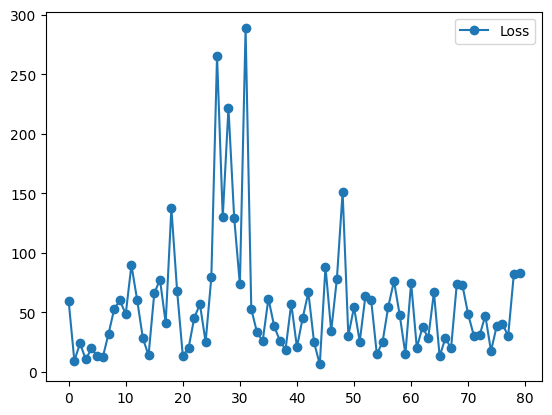

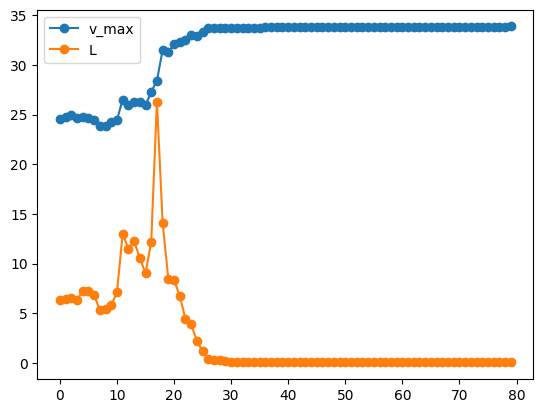

(np.float64(33.87233606638344), np.float64(0.10041134863811331))

In [164]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(J_arr)), J_arr, label="Loss", marker = "o")
ax = plt.gca()
# xmin, xmax = 3000, 8000
#ymin, ymax = 8, 9.5
#ax.set_ylim([ymin, ymax])
# ax.set_xlim([xmin, xmax])
plt.legend()
plt.savefig(f"Bilder/Figure_Loss{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
plt.plot(range(len(vmax_arr)), vmax_arr, label = "v_max", marker = "o")
plt.plot(range(len(L_arr)), L_arr, label = "L",  marker = "o")
plt.legend()
plt.savefig(f"Bilder/Figure_ParameterEntwicklung{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
v_max, L

# Gewichtung der gradienten für das update

In [16]:
 # from opt_lib_1 import *
dt = 0.01
L_in = 10 # 15
L = L_in
vmax_in = 25 # 30
v_max = vmax_in
N = 4
M = 100 # 5000
# # Datensatz 3
# L = 5 
# v_max = 30
# N = 1
# M = 5000 
# dt = 0.02
# sigma = 0.001
gradients = np.empty((2, N))
vmax_arr = []
L_arr = []
sigma = np.array([1/(2**i) for i in np.arange(0,30)]) # Amijo Bed.
np.random.seed(42)
grad_arr = np.empty((M, 2))
J_arr_sammel = np.empty(N) 
J_arr = []
dataset_nuber = 3# 5, 10
fileName = "TrafficDataset/sequence_data1-1_1.mat"
test = data_class(fileName)
gamma = 0.01 # erstmal fix



#random_samples = [dataset_nuber]
random_samples = np.random.randint(0, test.get_len()-1, (N))
for k, sample in enumerate(random_samples):
        test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
        Pges = test.pGes(dt, v_max)
        d = np.array([test.d(i) for i in test.get_x().T]).T
        Teil_grad = test.gradient(Pges, d, v_max, L, dt)
        # (update stepsize) bei uns fix
        gradients[:, k] = Teil_grad
        J_arr_sammel[k] = test.get_J()
mittel_grad = np.sum(gradients, 1)/N
J_initial = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]

Weiter = True
for j in range(M):
    #random_samples = [dataset_nuber]
    if j != 0:
        random_samples = np.random.randint(0, test.get_len()-1, (N))
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
            Pges = test.pGes(dt, v_max)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, v_max, L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
            
        mittel_grad = np.sum(gradients, 1)/N
        J_alt = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
    else:
        J_alt = J_initial
    for sig in sigma:
        kurz_vmax = v_max + sig * mittel_grad[0]
        kurz_L = L + sig * mittel_grad[1]
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            J_arr_sammel[k] = test.get_J()
            
        J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
        if J_mittel - J_alt <= (-1) * sig * gamma * np.power(np.linalg.norm(mittel_grad), 2):
            print(f"Sigma hat funktioniert: {sig}")
            Weiter = True
            break
        if sig == np.min(sigma):
            print(f"Kein Sigma gefunden in iteration: {j}, mit grad = {np.power(np.linalg.norm(mittel_grad), 2)}")
            Weiter = False
    if Weiter:
        # für die gewählte Schrittweite die adjungierte etc bestimmen
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            Pges = test.pGes(dt, kurz_vmax)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, kurz_vmax, kurz_L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
            
        mittel_grad = np.sum(gradients, 1)/N
        J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
        # Das entsprechende Update mit ausgerechneter Schrittweite machen
        if v_max + sig* mittel_grad[0] > 0:
            v_max = v_max + sig * mittel_grad[0]
        if L + sig * mittel_grad[1] > 0:
            L = L + sig * mittel_grad[1]
        J_arr.append(J_mittel)
        J_vgl = J_mittel
        vmax_arr.append(v_max)
        L_arr.append(L)
        grad_arr[j,:] = mittel_grad
        
    

/tmp/ipykernel_2601/2748071197.py:128: RuntimeWarning: invalid value encountered in log
  v = v_max * np.log(d)


Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 1, mit grad = 8.451370206816142
Sigma hat funktioniert: 0.5
Kein Sigma gefunden in iteration: 3, mit grad = 0.8651795083933365
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 7, mit grad = 7.887598001063171
Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 9, mit grad = 4609080.773276084
Kein Sigma gefunden in iteration: 10, mit grad = 0.41554425676657525
Sigma hat funktioniert: 0.5
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.125
Sigma hat funktioniert: 0.25
Sigma hat funktioniert: 0.5
Sigma hat funktioniert: 0.5
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 21, mit grad = 131133477.64652865
Sigma hat funktioniert: 0.25
Kein Sigma gefunden in iteration: 23, mit grad = 3181414813.6035213
Sigma hat funktioniert: 0.25
Sigma hat f

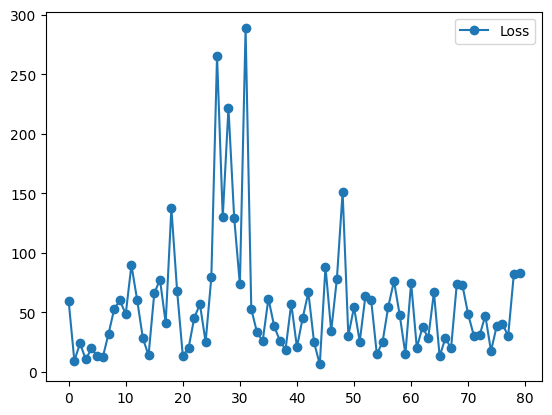

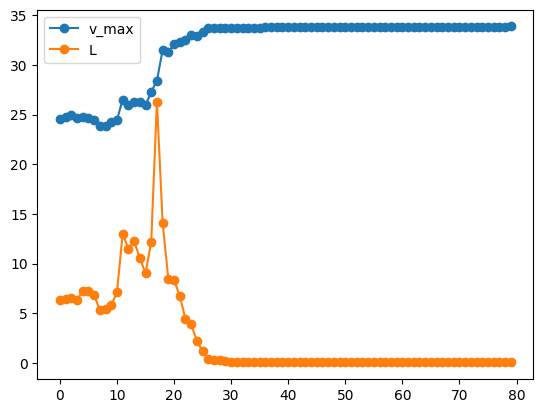

(np.float64(33.87233606638344), np.float64(0.10041134863811331))

In [17]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(J_arr)), J_arr, label="Loss", marker = "o")
ax = plt.gca()
# xmin, xmax = 3000, 8000
#ymin, ymax = 8, 9.5
#ax.set_ylim([ymin, ymax])
# ax.set_xlim([xmin, xmax])
plt.legend()
plt.savefig(f"Bilder/Figure_Loss{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
plt.plot(range(len(vmax_arr)), vmax_arr, label = "v_max", marker = "o")
plt.plot(range(len(L_arr)), L_arr, label = "L",  marker = "o")
plt.legend()
plt.savefig(f"Bilder/Figure_ParameterEntwicklung{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}sigma{sigma[0]}.pdf", dpi=40)
plt.show()
v_max, L

In [ ]:
# mittel_grad = np.sum(gradients, 1)/N
# ersetzen mit 
ignorieren = 2
order_mask = np.argsort(np.linalg.norm(gradients, axis=0)) # nach i-ter achse sortieren, hier x achse -> 0
gradients_ordered = gradients[:,order_mask]
mittel_grad = np.sum(gradients_ordered[:, : N-ignorieren], 1)/(N-ignorieren)
mittel_old = np.sum(gradients, 1)/N
mittel_grad, mittel_old

def fMittelGrad(grads, ignore):
	order_mask = np.argsort(np.linalg.norm(grads, axis=0)) # nach i-ter achse sortieren, hier x achse -> 0
	grads_ordered = grads[:,order_mask]
	mittel_grad = np.sum(grads_ordered[:, : N-ignore], 1)/(N-ignore)
	return mittel_grad



(array([ 2.14149667, -0.23663165]), array([ 9.84255498, 25.02058052]))

In [75]:
from opt_lib_1 import *
def fMittelGrad(grads, J_arr, ignore, N):
	order_mask = np.argsort(np.linalg.norm(grads, axis=0)) # nach i-ter achse sortieren, hier x achse -> 0
	grads_ordered = grads[:,order_mask]
	J_arr_ordered = J_arr[order_mask]
	mittel_grad = np.sum(grads_ordered[:, : N-ignore], 1)/(N-ignore)
	mittel_J_arr = np.sum(J_arr_ordered[: N-ignore])/(N-ignore)
	return mittel_grad, mittel_J_arr

ignorieren = 1
# from opt_lib_1 import *
dt = 0.01
L_in = 10 # 15
L = L_in
vmax_in = 25 # 30
v_max = vmax_in
N = 4
M = 30 # 5000
# # Datensatz 3
# L = 5 
# v_max = 30
# N = 1
# M = 5000 
# dt = 0.02
# sigma = 0.001
gradients = np.empty((2, N))
vmax_arr = []
L_arr = []
sigma = np.array([1/(2**i) for i in np.arange(0,30)]) # Amijo Bed.
seed = 50
np.random.seed(seed)
grad_arr = np.empty((M, 2))
J_arr_sammel = np.empty(N) 
J_arr = []
dataset_nuber = 3# 5, 10
fileName = "TrafficDataset/sequence_data1-1_1.mat"
test = data_class(fileName)
gamma = 0.01 # erstmal fix



#random_samples = [dataset_nuber]
random_samples = np.random.randint(0, test.get_len()-1, (N))
for k, sample in enumerate(random_samples):
        test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
        Pges = test.pGes(dt, v_max)
        d = np.array([test.d(i) for i in test.get_x().T]).T
        Teil_grad = test.gradient(Pges, d, v_max, L, dt)
        # (update stepsize) bei uns fix
        gradients[:, k] = Teil_grad
        J_arr_sammel[k] = test.get_J()
mittel_grad, J_initial = fMittelGrad(gradients, J_arr_sammel, ignorieren, N)

Weiter = True
for j in range(M):
    #random_samples = [dataset_nuber]
    if j != 0:
        random_samples = np.random.randint(0, test.get_len()-1, (N))
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
            Pges = test.pGes(dt, v_max)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, v_max, L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
        mittel_grad, J_alt = fMittelGrad(gradients, J_arr_sammel, ignorieren, N)
    else:
        J_alt = J_initial
    for sig in sigma:
        kurz_vmax = v_max + sig * mittel_grad[0]
        kurz_L = L + sig * mittel_grad[1]
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            Pges = test.pGes(dt, v_max)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, v_max, L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
            
        _, J_mittel = fMittelGrad(gradients, J_arr_sammel, ignorieren, N)
        if J_mittel - J_alt <= (-1) * sig * gamma * np.power(np.linalg.norm(mittel_grad), 2):
            print(f"Sigma hat funktioniert: {sig}")
            Weiter = True
            break
        if sig == np.min(sigma):
            print(f"Kein Sigma gefunden in iteration: {j}, mit grad = {np.power(np.linalg.norm(mittel_grad), 2)}")
            Weiter = False
    if Weiter:
        # für die gewählte Schrittweite die adjungierte etc bestimmen
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            Pges = test.pGes(dt, kurz_vmax)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, kurz_vmax, kurz_L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
            
        mittel_grad, J_alt = fMittelGrad(gradients, J_arr_sammel, ignorieren, N)
        # Das entsprechende Update mit ausgerechneter Schrittweite machen
        if v_max + sig* mittel_grad[0] > 0:
            v_max = v_max + sig * mittel_grad[0]
        if L + sig * mittel_grad[1] > 0:
            L = L + sig * mittel_grad[1]
        J_arr.append(J_mittel)
        J_vgl = J_mittel
        vmax_arr.append(v_max)
        L_arr.append(L)
        grad_arr[j,:] = mittel_grad
        
    

Sigma hat funktioniert: 1.0


Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 0.5
Kein Sigma gefunden in iteration: 4, mit grad = 0.22260478747792
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 0.5
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0


/home/tim/Dokumente/GitEnv/Opt1/opt_lib_1.py:128: RuntimeWarning: invalid value encountered in log
  v = v_max * np.log(d)


Sigma hat funktioniert: 0.5
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 0.25


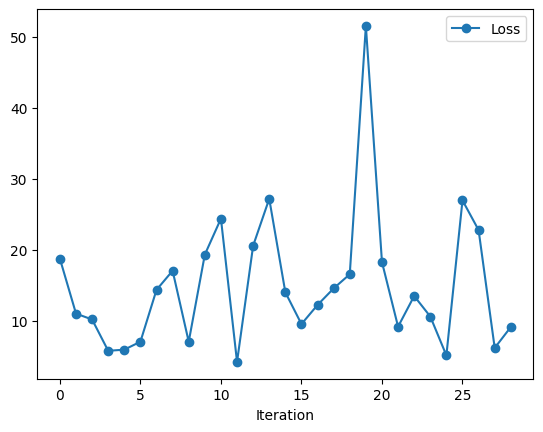

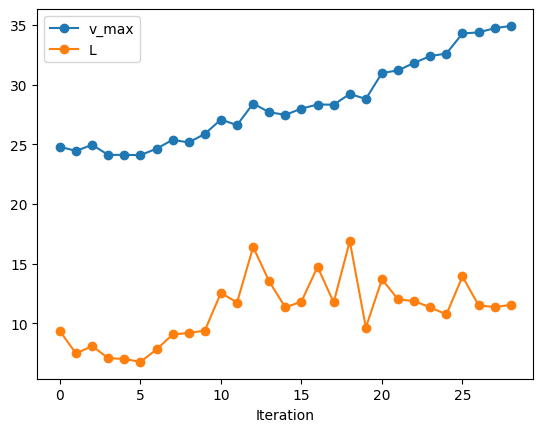

(np.float64(34.924695786230714), np.float64(11.527390338367383))

In [76]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(J_arr)), J_arr, label="Loss", marker = "o")
ax = plt.gca()
# xmin, xmax = 3000, 8000
#ymin, ymax = 8, 9.5
#ax.set_ylim([ymin, ymax])
# ax.set_xlim([xmin, xmax])
plt.legend()
plt.xlabel("Iteration")
plt.savefig(f"Bilder/Figure_Loss{fileName.split("/")[1].split(".")[0]}_random_M{M}L{L_in}Vmax{vmax_in}dt{dt}armijo_N{N}ign{ignorieren}seed{seed}.pdf", dpi=40)
plt.show()
plt.plot(range(len(vmax_arr)), vmax_arr, label = "v_max", marker = "o")
plt.plot(range(len(L_arr)), L_arr, label = "L",  marker = "o")
plt.legend()
plt.xlabel("Iteration")
plt.savefig(f"Bilder/Figure_ParameterEntwicklung{fileName.split("/")[1].split(".")[0]}_random_M{M}L{L_in}Vmax{vmax_in}dt{dt}armijo_N{N}ign{ignorieren}seed{seed}.pdf", dpi=40)
plt.show()
v_max, L

# Einzelner datensatz

In [22]:
from opt_lib_1 import *

def fMittelGrad(grads, ignore, N):
	order_mask = np.argsort(np.linalg.norm(grads, axis=0)) # nach i-ter achse sortieren, hier x achse -> 0
	grads_ordered = grads[:,order_mask]
	mittel_grad = np.sum(grads_ordered[:, : N-ignore], 1)/(N-ignore)
	return mittel_grad

ignorieren = 0
# from opt_lib_1 import *
dt = 0.005
L_in = 10 # 15
L = L_in
vmax_in = 25 # 30
v_max = vmax_in
N = 6
M = 500 # 5000
# # Datensatz 3
# L = 5 
# v_max = 30
# N = 1
# M = 5000 
# dt = 0.02
# sigma = 0.001
gradients = np.zeros((2, N))
vmax_arr = []
L_arr = []
sigma = np.array([1/(2**i) for i in np.arange(0,30)]) # Amijo Bed.
np.random.seed(42)
grad_arr = np.zeros((M, 2))
J_arr_sammel = np.empty(N) 
J_arr = []
dataset_nuber = 10# 5, 10
fileName = "TrafficDataset/sequence_data1-1_1.mat"
test = data_class(fileName)
gamma = 0.0001 # erstmal fix
sig_used = []


random_samples = [dataset_nuber]
#random_samples = np.random.randint(0, test.get_len()-1, (N))
for k, sample in enumerate(random_samples):
        test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
        Pges = test.pGes(dt, v_max)
        d = np.array([test.d(i) for i in test.get_x().T]).T
        Teil_grad = test.gradient(Pges, d, v_max, L, dt)
        # (update stepsize) bei uns fix
        gradients[:, k] = Teil_grad
        J_arr_sammel[k] = test.get_J()
mittel_grad = fMittelGrad(gradients, ignorieren, N)
J_initial = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]

Weiter = True
for j in range(M):
    if j != 0:
        random_samples = [dataset_nuber]
        #random_samples = np.random.randint(0, test.get_len()-1, (N))
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, L, v_max, model="log", n_dataset=sample)
            Pges = test.pGes(dt, v_max)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, v_max, L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
            
        mittel_grad = fMittelGrad(gradients, ignorieren, N)
        J_alt = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
    else:
        J_alt = J_initial
    for sig in sigma:
        kurz_vmax = v_max + sig * mittel_grad[0]
        kurz_L = L + sig * mittel_grad[1]
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            J_arr_sammel[k] = test.get_J()
            
        J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
        if J_mittel - J_alt <= (-1) * sig * gamma * np.power(np.linalg.norm(mittel_grad), 2):
            print(f"Sigma hat funktioniert: {sig}")
            sig_used.append(sig)
            Weiter = True
            break
        if sig == np.min(sigma):
            print(f"Kein Sigma gefunden in iteration: {j}, mit grad = {np.power(np.linalg.norm(mittel_grad), 2)}")
            Weiter = False
    if Weiter:
        # für die gewählte Schrittweite die adjungierte etc bestimmen
        for k, sample in enumerate(random_samples):
            test.set_numx(dt, kurz_L, kurz_vmax, model="log", n_dataset=sample)
            Pges = test.pGes(dt, kurz_vmax)
            d = np.array([test.d(i) for i in test.get_x().T]).T
            Teil_grad = test.gradient(Pges, d, kurz_vmax, kurz_L, dt)
            # (update stepsize) bei uns fix
            gradients[:, k] = Teil_grad
            J_arr_sammel[k] = test.get_J()
            
        mittel_grad = fMittelGrad(gradients, ignorieren, N)
        J_mittel = np.sum(J_arr_sammel)/J_arr_sammel.shape[0]
        # Das entsprechende Update mit ausgerechneter Schrittweite machen
        if v_max + sig* mittel_grad[0] > 0:
            v_max = v_max + sig * mittel_grad[0]
        if L + sig * mittel_grad[1] > 0:
            L = L + sig * mittel_grad[1]
        J_arr.append(J_mittel)
        J_vgl = J_mittel
        vmax_arr.append(v_max)
        L_arr.append(L)
        grad_arr[j,:] = mittel_grad
    else:
        break

Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktioniert: 1.0
Sigma hat funktionie

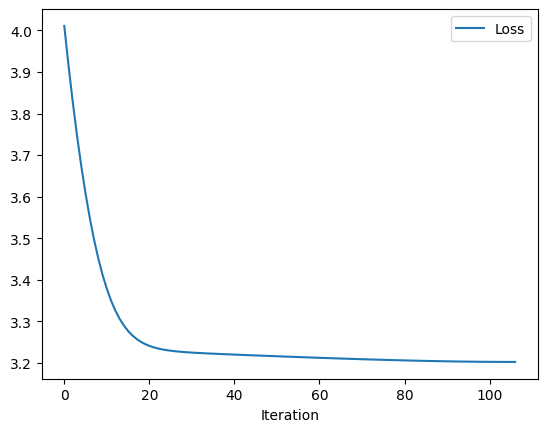

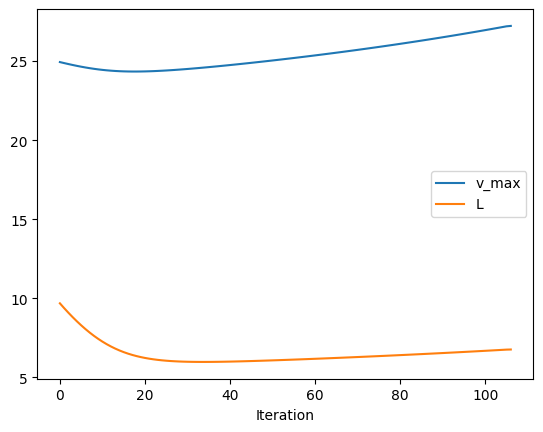

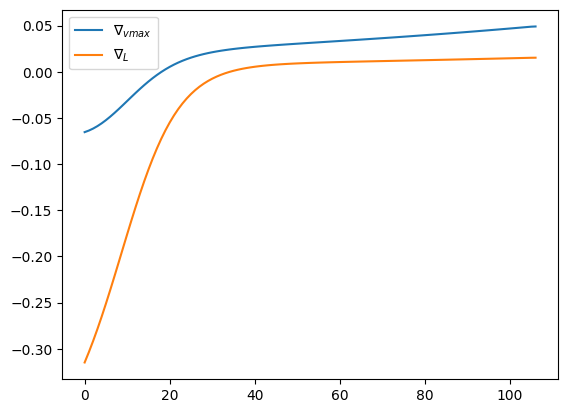

(np.float64(27.2200152962219), np.float64(6.766043013836448))

In [26]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(J_arr)), J_arr, label="Loss", marker = "")
ax = plt.gca()
# xmin, xmax = 3000, 8000
#ymin, ymax = 8, 9.5
#ax.set_ylim([ymin, ymax])
# ax.set_xlim([xmin, xmax])
plt.legend()
plt.xlabel("Iteration")
plt.savefig(f"Bilder/{fileName.split("/")[1].split(".")[0]}_single{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}armijo_gamma{gamma}_Figure_Loss.pdf", dpi=40)
plt.show()
plt.plot(range(len(vmax_arr)), vmax_arr, label = "v_max", marker = "")
plt.plot(range(len(L_arr)), L_arr, label = "L",  marker = "")
plt.legend()
plt.xlabel("Iteration")
plt.savefig(f"Bilder/{fileName.split("/")[1].split(".")[0]}_single{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}armijo_gamma{gamma}_Figure_ParameterEntwicklung.pdf", dpi=40)
plt.show()
mask = grad_arr == 0
grad = grad_arr[:int(np.min(np.where(mask)[0])), :]
plt.plot(range(grad.shape[0]), grad[:,0], label=r"$\nabla_{vmax}$", marker = "")
plt.plot(range(grad.shape[0]), grad[:,1], label=r"$\nabla_{L}$", marker = "")
plt.legend()
plt.savefig(f"Bilder/{fileName.split("/")[1].split(".")[0]}_single{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}armijo_gamma{gamma}_Figure_GradEntwicklung.pdf", dpi=40)
plt.show()
v_max, L

# Gradiententest

In [27]:
def Grad_test(J, vmax, l):
    grad_v = [(J_i - J_ip)/v_i-v_ip for J_i, J_ip, v_i, v_ip in zip(J[:-1], J[1:], vmax[:-1], vmax[1:]) ]
    grad_l = [(J_i - J_ip)/l_i-l_ip for J_i, J_ip, l_i, l_ip in zip(J[:-1], J[1:], l[:-1], l[1:]) ]
    return np.array([grad_v, grad_l]).T

def Grad_test_sig(J, sig_arr):
    grad_v = [(J_i - J_ip)/sig_i for J_i, J_ip, sig_i in zip(J[:-1], J[1:], sig_arr)]
    return np.array(grad_v)

grad_vgl = Grad_test_sig(J_arr, sig_used)

grad_vgl.shape

(106,)

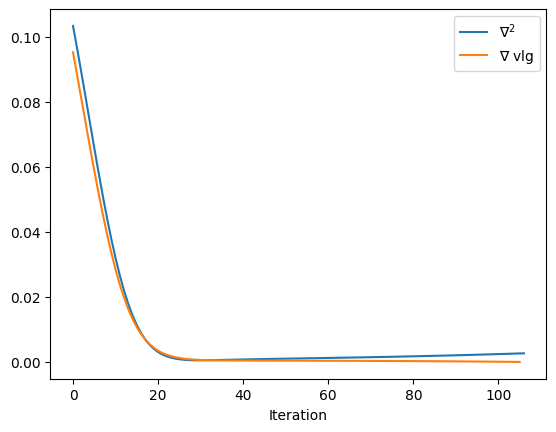

In [29]:
mask = grad_arr == 0
grad = grad_arr[:int(np.min(np.where(mask)[0])), :]
# plt.plot(range(grad.shape[0]), grad[:,0], label=r"$\nabla_{vmax}$", marker = "")
# plt.plot(range(grad.shape[0]), grad[:,1], label=r"$\nabla_{L}$", marker = "")
plt.plot(range(grad.shape[0]), np.power(np.linalg.norm(grad, axis = 1), 2), label=r"$\nabla^2$", marker = "")
plt.plot(range(grad_vgl.shape[0]), grad_vgl, label=r"$\nabla$ vlg", marker = "")
# plt.plot(range(grad_vgl.shape[0]), grad_vgl[:,1], label=r"$\nabla_{L}$ vlg", marker = "")
plt.xlabel("Iteration")
plt.legend()
plt.savefig(f"Bilder/{fileName.split("/")[1].split(".")[0]}_single{dataset_nuber}_M{M}L{L_in}Vmax{vmax_in}dt{dt}armijo_gamma{gamma}_Figure_Gradvgl.pdf", dpi=40)
plt.show()


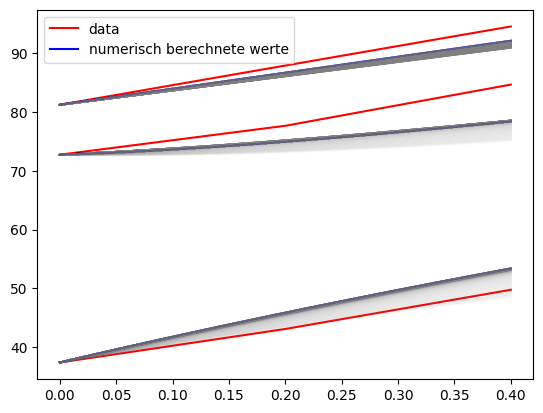

In [52]:
# OPtimiierungs prozess an trajektoreien zeigen
for i in range(test.get_x().shape[0]):
	if i == 0: 
		plt.plot(test.get_t(), test.get_x()[0,:], label="data", color = "r")
		plt.plot(test.get_t(),test.get_numx()[0,:],label="numerisch berechnete werte", color = "b")
	else:
		plt.plot(test.get_t(), test.get_x()[i,:], color = "r")
		plt.plot(test.get_t(),test.get_numx()[i,:], color = "b")

max = len(test.get_gesnumx())
for i in np.arange(0, max, 1):
    for j in range(test.get_x().shape[0]):
    	plt.plot(test.get_t(), test.get_gesnumx()[i][j,:], alpha = 0.03, color="gray")
plt.legend()
plt.savefig(f"Bilder/{fileName.split("/")[1].split(".")[0]}_{dataset_nuber}_armijo_Figure_Ges_IterationShadow.pdf", dpi=40)
plt.show()
